In [90]:
#General imports

In [91]:
import os
import joblib

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode

In [93]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
#Machine Learning imports

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [96]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [97]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, StackingRegressor

In [98]:
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Import & Aggregation

In [99]:
DATA_PATH = 'C:\\My Work\\Projects\\Machine Learning\\Walmart Sales Forecasting\\datasets\\'#local folder

In [100]:
print('Loading data...')
print(os.listdir(DATA_PATH))

Loading data...
['features.csv', 'stores.csv', 'test.csv', 'train.csv']


In [101]:
FEATURE_PATH = DATA_PATH + 'features.csv'
STORES_PATH = DATA_PATH + 'stores.csv'
TRAIN_PATH = DATA_PATH + 'train.csv'
TEST_PATH = DATA_PATH + 'test.csv'

In [102]:
#Created variables for each dataset path is to make this portion less dependent.
#Even if I need to change or move the data to somewhere else, the effort will be minimal
#A better option would have been to create a config file for the same.

In [103]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
features = pd.read_csv(FEATURE_PATH)
stores = pd.read_csv(STORES_PATH)

In [104]:
train.head(20)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [105]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [106]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [107]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [108]:
#merging the data

class DataMerger(BaseEstimator, TransformerMixin):
    def __init__(self,fpath = FEATURE_PATH, spath = STORES_PATH):
        self.fpath = fpath
        self.spath = spath
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        feature = pd.read_csv(self.fpath)
        store = pd.read_csv(self.spath)
        df = X.merge(feature, how = 'inner', on =['Store', 'Date', 'IsHoliday'])
        df = df.merge(store, how = 'inner', on =['Store'])
        return df

In [109]:
dm = DataMerger(FEATURE_PATH, STORES_PATH)
trainSales = dm.transform(train)
trainSales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


# 2. Data Analysis

In [110]:
trainSales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [111]:
target = ['Weekly_Sales']
markDown = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
numCols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
otherCols = []

for col in trainSales.columns:
    if (col not in numCols) and (col not in target) and (col not in markDown):
        otherCols.append(col)
        
otherCols

['Store', 'Dept', 'Date', 'IsHoliday', 'Type']

***Check IsHoliday***

In [112]:
trainSales['IsHoliday'].value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

In [113]:
#Create a new column with values 1 & 0 for True & False respectively

# ohe = OneHotEncoder(drop='first', dtype='int')
# holidayDummies = ohe.fit_transform(trainSales[['IsHoliday']]).toarray()
# trainSales['HolidayFlag'] = holidayDummies
# holidaySales = trainSales.drop(columns = ['IsHoliday'], axis=1)
# holidaySales.head()

In [114]:
trainSales['HolidayFlag'] = trainSales['IsHoliday'].apply(lambda x : 0 if x == False else 1)
holidaySales = trainSales.drop(columns = ['IsHoliday'], axis=1)
holidaySales.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,HolidayFlag
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0


***Check Type***

In [115]:
#holidaySales['Type'].value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [116]:
#Create dummies using OneHotEncoding

# ohe = OneHotEncoder(dtype='int')
# typeDummies = ohe.fit_transform(holidaySales[['Type']]).toarray()
# holidaySales[['type_A', 'type_B', 'type_C']] = typeDummies
# typeSales = holidaySales.drop(['Type'], axis=1)
# typeSales.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,HolidayFlag,type_A,type_B,type_C
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0


***Check Date***

In [117]:
#Lets have seperate columns for month, year and week
#Can we also get the date whether it is weekend or not?

typeSales['Year'] = typeSales['Date'].astype('datetime64').dt.year
typeSales['Month'] = typeSales['Date'].astype('datetime64').dt.month
#typeSales['WeekDay'] = typeSales['Date'].astype('datetime64').dt.weekday
#typeSales['Week'] = typeSales['Date'].astype('datetime64').dt.isocalendar().week
typeSales.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,HolidayFlag,type_A,type_B,type_C,Year,Month
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0,2010,2
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0,2010,2
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0,2010,2
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0,2010,2
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0,2010,2


In [118]:
def week_of_month(df):
    dff = df.copy()
    dff['date_week'] = dff['Date'].astype('datetime64').dt.isocalendar().week
    dff['date_month'] = dff['Date'].astype('datetime64').dt.month
    dff['date_year'] = dff['Date'].astype('datetime64').dt.year
    
    dff[['date_start']] = '01'
    
    dff['ref_date'] = dff['date_year'].astype('str') + '-' + dff['date_month'].astype('str') + '-' + dff['date_start'].astype('str')
    dff['ref_week'] = dff['ref_date'].astype('datetime64').dt.isocalendar().week
    dff.loc[dff['ref_week'] == 52, 'ref_week'] = 0
    
    dff['WOM'] = (dff['date_week'] - dff['ref_week']) + 1
    
    return dff['WOM']

In [119]:
typeSales['Week_of_Month'] = week_of_month(typeSales[['Date']])

typeSales.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,CPI,Unemployment,Size,HolidayFlag,type_A,type_B,type_C,Year,Month,Week_of_Month
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,...,211.096358,8.106,151315,0,1,0,0,2010,2,1
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,...,211.096358,8.106,151315,0,1,0,0,2010,2,1
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,...,211.096358,8.106,151315,0,1,0,0,2010,2,1
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,...,211.096358,8.106,151315,0,1,0,0,2010,2,1
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,...,211.096358,8.106,151315,0,1,0,0,2010,2,1


In [120]:
#Due to some reason it is being observed that sales information taken only on Friday 
#and not on other days regardless of the year

#If that is true then maybe we need to revisit our strategy on the date columns 

#We do not need any validation for weekend 'coz no date ins a weekend.

In [121]:
typeSales['Year'].unique()

array([2010, 2011, 2012], dtype=int64)

In [122]:
typeSales.shape

(421570, 21)

In [123]:
typeSales.isnull().sum()

Store                 0
Dept                  0
Date                  0
Weekly_Sales          0
Temperature           0
Fuel_Price            0
MarkDown1        270889
MarkDown2        310322
MarkDown3        284479
MarkDown4        286603
MarkDown5        270138
CPI                   0
Unemployment          0
Size                  0
HolidayFlag           0
type_A                0
type_B                0
type_C                0
Year                  0
Month                 0
Week_of_Month         0
dtype: int64

In [124]:
#More than half of the rows are null for the Markdown columns
#Since I do not have much information available about these columns, removing these.
#Date column can be removed now.

sales = typeSales.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown4', 'MarkDown5', 'Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Store          421570 non-null  int64  
 1   Dept           421570 non-null  int64  
 2   Weekly_Sales   421570 non-null  float64
 3   Temperature    421570 non-null  float64
 4   Fuel_Price     421570 non-null  float64
 5   CPI            421570 non-null  float64
 6   Unemployment   421570 non-null  float64
 7   Size           421570 non-null  int64  
 8   HolidayFlag    421570 non-null  int64  
 9   type_A         421570 non-null  int32  
 10  type_B         421570 non-null  int32  
 11  type_C         421570 non-null  int32  
 12  Year           421570 non-null  int64  
 13  Month          421570 non-null  int64  
 14  Week_of_Month  421570 non-null  UInt32 
dtypes: UInt32(1), float64(5), int32(3), int64(6)
memory usage: 45.4 MB


In [125]:
sales.isnull().sum()

Store            0
Dept             0
Weekly_Sales     0
Temperature      0
Fuel_Price       0
CPI              0
Unemployment     0
Size             0
HolidayFlag      0
type_A           0
type_B           0
type_C           0
Year             0
Month            0
Week_of_Month    0
dtype: int64

In [126]:
sales.sample(10)

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,HolidayFlag,type_A,type_B,type_C,Year,Month,Week_of_Month
231143,24,92,108858.93,36.88,3.789,133.958742,8.252,203819,0,1,0,0,2011,3,4
406765,44,90,29547.94,42.55,2.831,126.546161,7.610,39910,0,0,0,1,2010,11,2
356762,38,95,42288.02,63.63,3.772,128.719935,13.736,39690,0,0,0,1,2011,4,1
221489,23,81,7799.92,55.12,4.095,134.593000,4.781,114533,0,0,1,0,2011,5,3
205419,21,42,5941.47,77.53,3.749,221.309517,6.891,140167,0,0,1,0,2012,5,1
108180,12,3,16045.09,53.77,2.987,126.578286,13.975,112238,0,0,1,0,2010,3,1
321236,34,67,5353.45,51.26,2.773,126.601903,9.593,158114,0,1,0,0,2010,4,2
392141,42,9,149.12,91.80,2.971,126.149806,9.199,39690,0,0,0,1,2010,7,3
364116,39,94,45083.74,53.55,2.708,210.376263,8.476,184109,0,1,0,0,2010,12,1
402545,43,97,16781.21,47.49,3.172,210.312607,10.148,41062,0,0,0,1,2011,12,1


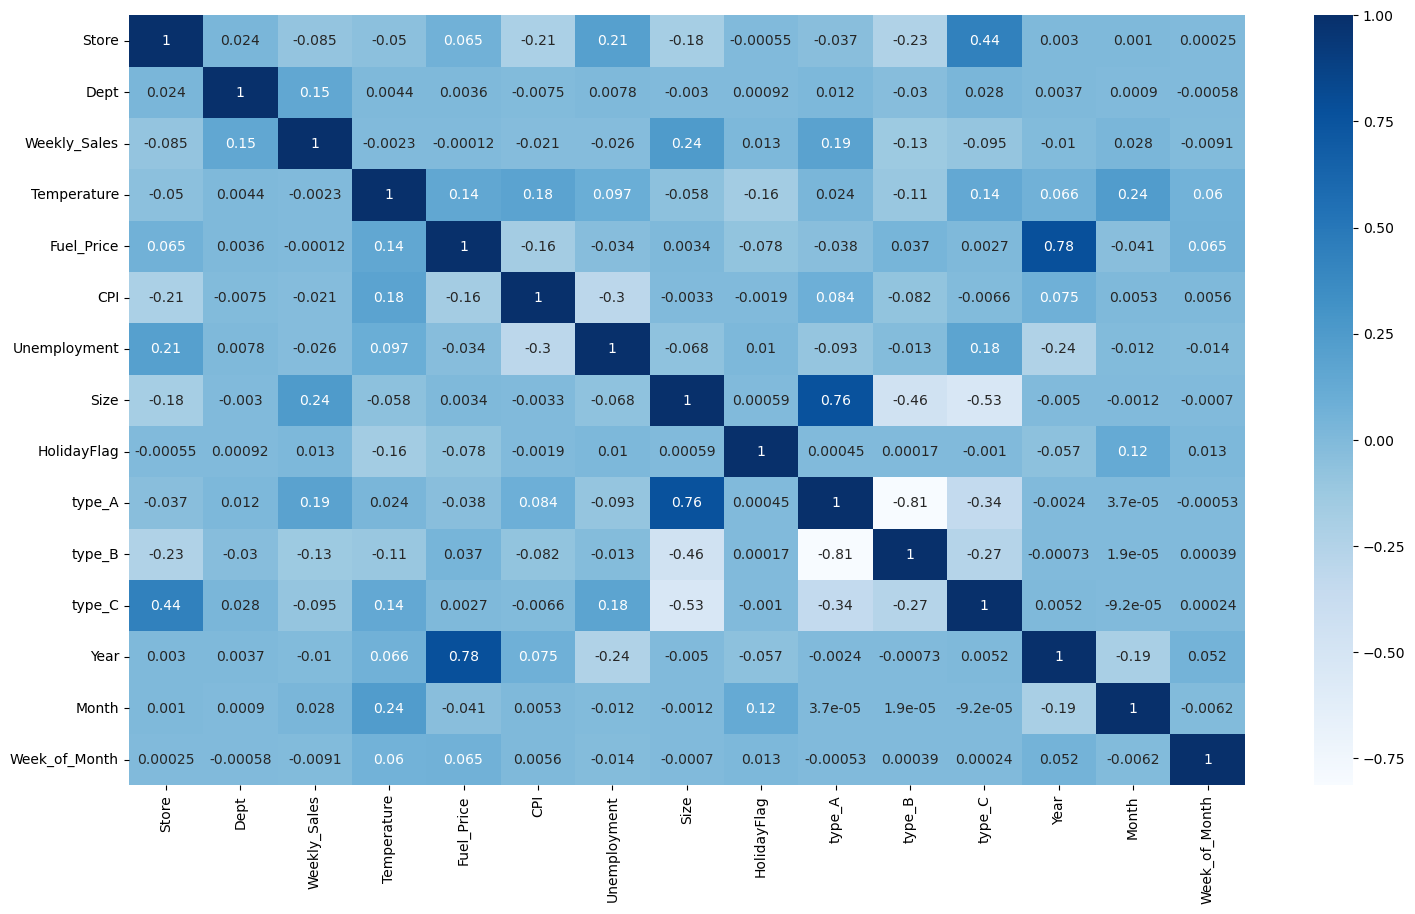

In [127]:
#Lets try to see the inter-dependebcy among the columns

plt.figure(figsize=(18, 10))

sales_cr = sales.corr()
sns.heatmap(sales_cr, annot=True, cmap='Blues')
plt.show()

In [ ]:
numeric_columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'size']
category_columns = ['Store', 'Dept', 'HolidayFlag']

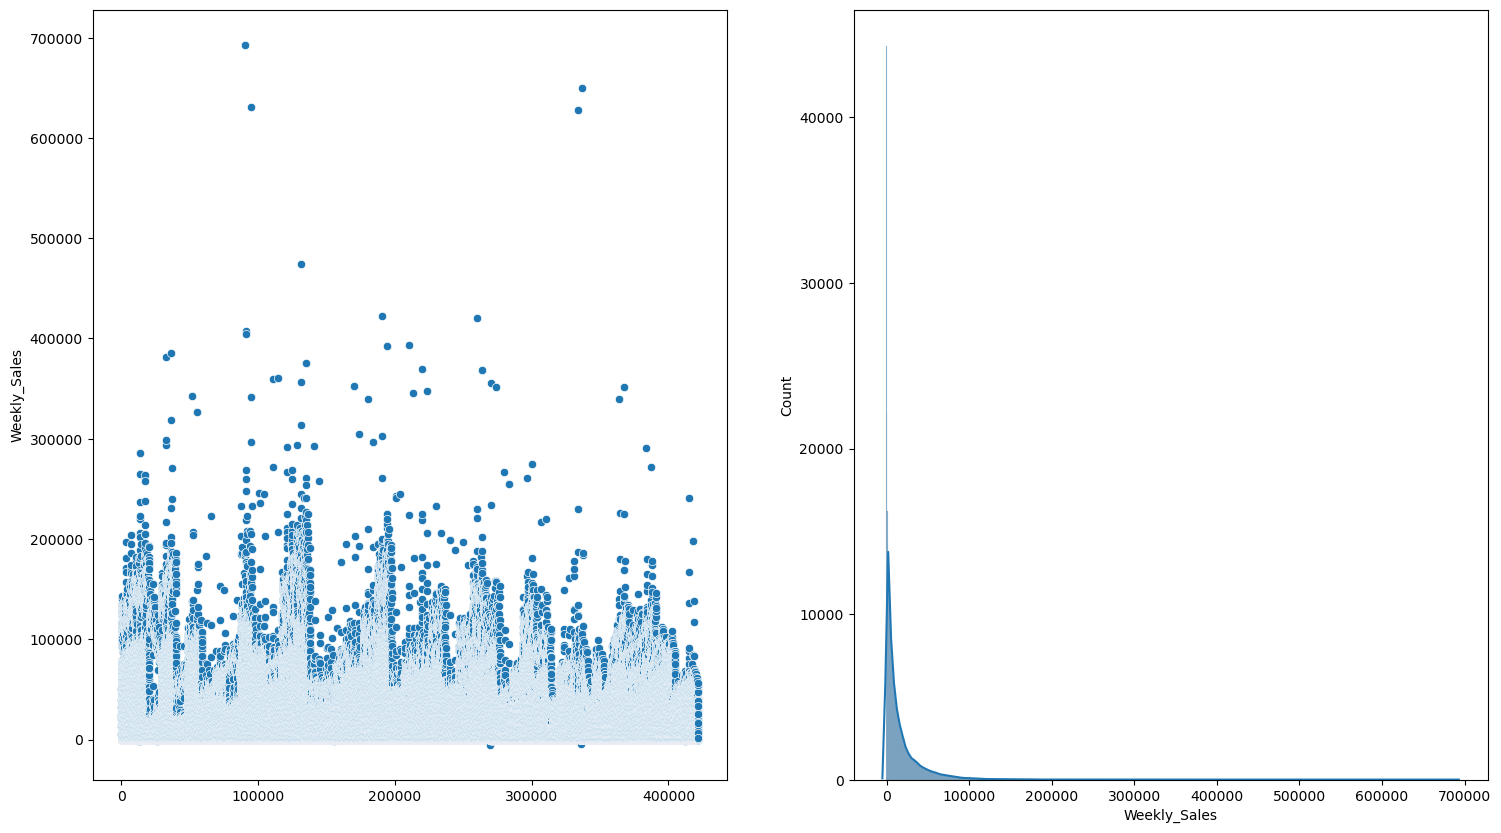

In [130]:
#Plotting the target

fig, ax = plt.subplots(1, 2, figsize=(18, 10))

sns.scatterplot(y='Weekly_Sales', x = sales.index, data=sales, ax = ax[0])
sns.histplot(x = 'Weekly_Sales', data=sales, kde=True, ax = ax[1])
fig.show()

In [ ]:
#Lets try to plot the sales per year


sns.barplot(x = years , y = list(total_sales.values()))
plt.title('Year-Wise Sales Comparison')
plt.ylabel('Weekly Sales')
plt.show()

In [ ]:
sns.barplot(x = 'Month', y = 'Weekly_Sales', data=typeSales)

***Before proceeding further lets check back what have we done so far***

- Merged all data: pickle created
- Created column 'HolidayFlag' with values 1 & 0.
- Created dummies for column 'Type'
- Segregated 'Date' column as 'Year', 'Month', 'Week' and 'IsWeekend' (values 0 & 1)
- Overriden the NaN values for 'MarkDown*' columns with their corresponding mean for that each store.

***Data Pipeline Preparation***

- numCols: replace missing values with mean
- otherCols: replace missing values with ???